## CBOE SKEW analysis

#### Implement the CBOE SKEW Index as outlined in the CBOE's white paper https://www.cboe.com/micro/skew/documents/skewwhitepaperjan2011.pdf

The CBOE publishes an Index called SKEW, which attempts to tract the volatility skew across strikes (vertical) on options that trade against the SPX (SP 500) Options, for each trading day.  The SKEW index calculation uses Out-of-the-Money (OTM) options on the first and second nearby SPX options expiries.  A portfolio of these options, weighted by the amount that each option is out of the money, emulates 



In [1]:
import sys,os

if  not os.path.abspath('./') in sys.path:
    sys.path.append(os.path.abspath('./'))
if  not os.path.abspath('../') in sys.path:
    sys.path.append(os.path.abspath('../'))
from volgrid import dgrid
from volgrid import create_voltables as cvt
import dash_core_components as dcc
import traceback

import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import  init_notebook_mode, iplot
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
from pandas.tseries.offsets import BDay
import pandas_datareader.data as pdr
import datetime
import pytz

#  do rest of imports
import dash
import dash_html_components as html
from dash.dependencies import Input, Output,State
import yfinance as yf
import pathlib
import pg_pandas as pg
from dateutil.relativedelta import *

### Define some interest rate and calendar functions

In [81]:
from pandas.tseries.holiday import USFederalHolidayCalendar
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())
TIMEZONE = 'US/Eastern'

def get_rate_df(num_months_for_rate=1,start_datetime=None,end_datetime=None):
    # see if you can get Libor from the FRED API
    if start_datetime is None:
        n = datetime.datetime.now() - 252*bday_us #datetime.timedelta(7)
    else:
        if type(start_datetime)==int:
            sdt = start_datetime
            n = datetime.datetime(int(str(sdt)[0:4]),int(str(sdt)[4:6]), int(str(sdt)[6:8]))
        else:
            n = start_datetime 
    y = n.year
    m = n.month
    d = n.day
    beg = '%04d-%02d-%02d' %(y,m,d)
    ed = end_datetime if end_datetime is not None else (datetime.datetime.now() - datetime.timedelta(1))
    if type(ed)==int:
        ed = datetime.datetime(int(str(ed)[0:4]), int(str(ed)[4:6]), int(str(ed)[6:8]))
    y = ed.year
    m = ed.month
    d = ed.day
    eds = '%04d-%02d-%02d' %(y,m,d)
    fred_libor_file = f'USD{num_months_for_rate}MTD156N'
    df = pdr.DataReader(fred_libor_file, "fred", f'{beg}', f'{eds}')
    if len(df)<1:
        raise ValueError(f'FRED calendar of {fred_libor_file} does not contain dates {beg} through {eds}')
    df['fixed_rate'] = df[f'USD{num_months_for_rate}MTD156N'].astype(float)/100
    df.columns = df.columns.get_level_values(0)
    df['date_yyyymmdd'] = [int(d.year*100*100) + int(d.month*100) + int(d.day) for d in df.index]
    df.index = range(len(df))
    df['prate'] = df.shift(1).fixed_rate
    df['fixed_rate'] = df.apply(lambda r:r.prate if r.fixed_rate !=r.fixed_rate else r.fixed_rate,axis=1)
    return df[['date_yyyymmdd','fixed_rate']]


def get_rate(num_months_for_rate=1,rate_datetime=None):
    # see if you can get Libor from the FRED API
    if rate_datetime is None:
        n = datetime.datetime.now() - 7*bday_us #datetime.timedelta(7)
    else:
        n = rate_datetime #- datetime.timedelta(14)
    y = n.year
    m = n.month
    d = n.day
    beg = '%04d-%02d-%02d' %(y,m,d)
#     ed = n  + datetime.timedelta(1)
    ed = datetime.datetime.now()
    y = ed.year
    m = ed.month
    d = ed.day
    eds = '%04d-%02d-%02d' %(y,m,d)
    fred_libor_file = f'USD{num_months_for_rate}MTD156N'
    df = pdr.DataReader(fred_libor_file, "fred", f'{beg}', f'{eds}')
    if len(df)<1:
        raise ValueError(f'FRED calendar of {fred_libor_file} does not contain dates {beg} through {eds}')
#     fixed_rate = float(df.iloc[len(df)-1][f'USD{num_months_for_rate}MTD156N'])/100
    fixed_rate = float(df.iloc[-1][f'USD{num_months_for_rate}MTD156N'])/100
    return fixed_rate

def get_nth_weekday(year,month,target_weekday,nth_occurrence):
    '''
    weekday is the term that assigns numbers from 0 to 6 to the days of the weeks.
    weekday 0 = monday
    '''
    # get dayofweeks of year,month,1
    weekday_01 = datetime.datetime(year,month,1).weekday()
    if weekday_01 <= target_weekday:
        day_of_month_of_first_occurence = target_weekday - weekday_01
        day_of_month_of_nth_occurence = day_of_month_of_first_occurence + 1 + (nth_occurrence - 1) * 7
    else:
        day_of_month_of_nth_occurence = target_weekday - weekday_01 + 1 + (nth_occurrence) * 7 
    return datetime.datetime(year,month,day_of_month_of_nth_occurence)


MONTH_CODES = 'FGHJKMNQUVXZ'
DICT_MONTH_CODE = {MONTH_CODES[i]:i+1 for i in range(len(MONTH_CODES))}


def get_ES_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return get_nth_weekday(year,month,4,3)

def get_E6_expiry(symbol):
    monthcode_yy = symbol[2:]
    next_month = DICT_MONTH_CODE[monthcode_yy[0]] + 1
    year = 2000 + int(monthcode_yy[1:])
    if next_month>12:
        next_month = 1
        year += 1
    return datetime.datetime(year,next_month,1) - 7*bday_us

def get_CL_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month -1
    if month<1:
        month = 12
        year = year - 1
    return datetime.datetime(year,month,26) - 7*bday_us

def get_CB_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    month = month - 1
    if month<1:
        month = 12 + month
        year = year - 1
    return datetime.datetime(year,month,1) - 4*bday_us

def get_NG_expiry(symbol):
    monthcode_yy = symbol[2:]
    month = DICT_MONTH_CODE[monthcode_yy[0]]
    year = 2000 + int(monthcode_yy[1:])
    return datetime.datetime(year,month,1) - 4*bday_us

DICT_PRODUCT = {
    'E6':get_E6_expiry,
    'ES':get_ES_expiry,
    'CL':get_CL_expiry,
    'CB':get_CB_expiry,
    'NG':get_NG_expiry,
}

    
def get_expiry(symbol):
    product = symbol[:2]
    f = DICT_PRODUCT[product]
    return f(symbol)


def dt_from_yyyymmdd(yyyymmdd,hour=0,minute=0,timezone=TIMEZONE):
    y = int(str(yyyymmdd)[0:4])
    m = int(str(yyyymmdd)[4:6])
    d = int(str(yyyymmdd)[6:8])  
    return datetime.datetime(y,m,d,hour,minute,tzinfo=pytz.timezone(timezone))

def yyyymmdd_from_dt(dt):
    y = int(dt.year)
    m = int(dt.month)
    d = int(dt.day)
    return y*100*100 + m*100 + d

def get_dte_pct(trade_yyyymmdd,expiry_yyyymmdd):
    dt_td = dt_from_yyyymmdd(trade_yyyymmdd)
    dt_xp = dt_from_yyyymmdd(expiry_yyyymmdd)
    return ((dt_xp - dt_td).days + 1)/365



### check dates vs last records in db for CL and ES

In [3]:
# pg.PgPandas??
pga = pg.PgPandas(dburl='127.0.0.1',username='',password='',databasename='sec_db')

/Users/bperlman1/Virtualenvs3/dashrisk3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning:

The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.



In [71]:
def get_min_max_dates(symbol):
    sql = f'''
    select min(ot.settle_date) min_date, max(ot.settle_date) max_date from sec_schema.options_table ot
    where ot.symbol='{symbol}' 
    ;
    '''
    r = pga.get_sql(sql).iloc[0]
    return r.min_date, r.max_date
    
    

In [73]:
get_min_max_dates('CLF17')

(20150803, 20161215)

In [82]:
syms = ['CB'+m+yy for m in 'FGHJKMNQUVXZ' for yy in ['15','16','17','18','19']]
for s in syms:
    ge = str(get_expiry(s))
    exp1 = int(ge[0:4])*100*100 + int(ge[5:7])*100 + int(ge[8:10])
    
    sql = f'''
    select max(ot.settle_date) from sec_schema.options_table ot
    where ot.symbol='{s}' 
    ;
    '''
    df_options = pga.get_sql(sql)
    exp2 = df_options.iloc[0]['max']
    print(s,exp1,exp2,exp1==exp2)
    #assert(exp1==exp2)

CBF15 20141124 20141211 False
CBF16 20151124 20151211 False
CBF17 20161125 20161125 True
CBF18 20171127 20171127 True
CBF19 20181127 20181127 True
CBG15 20141226 20150112 False
CBG16 20151228 20160111 False
CBG17 20161227 20161222 False
CBG18 20171226 20171221 False
CBG19 20181226 20181221 False
CBH15 20150127 20150209 False
CBH16 20160126 20160126 True
CBH17 20170126 20170126 True
CBH18 20180126 20180126 True
CBH19 20190128 20190128 True
CBJ15 20150224 20150311 False
CBJ16 20160224 20160224 True
CBJ17 20170223 20170223 True
CBJ18 20180223 20180223 True
CBJ19 20190225 20190225 True
CBK15 20150326 20150410 False
CBK16 20160328 20160324 False
CBK17 20170328 20170328 True
CBK18 20180327 20180326 False
CBK19 20190326 20190326 True
CBM15 20150427 20150511 False
CBM16 20160426 20160426 True
CBM17 20170425 20170425 True
CBM18 20180425 20180425 True
CBM19 20190425 20190425 True
CBN15 20150526 20150610 False
CBN16 20160525 20160525 True
CBN17 20170525 20170525 True
CBN18 20180525 20180525 True


In [5]:
get_rate(1)#,rate_datetime=datetime.datetime(2020,1,1))

0.0179938

In [6]:
rdf = get_rate_df(1,datetime.datetime(2018,8,1),datetime.datetime(2018,8,31))
rdf

,date_yyyymmdd,fixed_rate
0,20180801,0.020821
1,20180802,0.020802
2,20180803,0.020793
3,20180806,0.020826
4,20180807,0.020711
5,20180808,0.020634
6,20180809,0.020673
7,20180810,0.020667
8,20180813,0.020627
9,20180814,0.020635


### Paremeters to calculate SPX based SKEW

In [7]:
SKEW_TICKER = '^SPX' # yahoo symbol


In [8]:
df_skew = pd.read_csv('https://www.cboe.com/publish/scheduledtask/mktdata/datahouse/skewdailyprices.csv',header=1)

In [9]:
df_skew['date_split'] = df_skew.Date.apply(lambda s:s.split('/'))
df_skew['yyyymmdd'] = df_skew.date_split.apply(lambda s:int(s[2])*100*100 + int(s[0])*100 + int(s[1]))
df_skew

,Date,SKEW,Unnamed: 2,Unnamed: 3,date_split,yyyymmdd
0,1/2/1990,126.09,NaN,NaN,"[1, 2, 1990]",19900102
1,1/3/1990,123.34,NaN,NaN,"[1, 3, 1990]",19900103
2,1/4/1990,122.62,NaN,NaN,"[1, 4, 1990]",19900104
3,1/5/1990,121.27,NaN,NaN,"[1, 5, 1990]",19900105
4,1/8/1990,124.12,NaN,NaN,"[1, 8, 1990]",19900108
...,...,...,...,...,...,...
7545,12/27/2019,140.29,NaN,NaN,"[12, 27, 2019]",20191227
7546,12/30/2019,133.56,NaN,NaN,"[12, 30, 2019]",20191230
7547,12/31/2019,139.52,NaN,NaN,"[12, 31, 2019]",20191231
7548,01/02/2020,137.70,NaN,NaN,"[01, 02, 2020]",20200102


In [10]:
def get_closest_expiry_to_dt(dt=None,options_ticker=SKEW_TICKER):
    nn = dt
    if nn is None:
        nn = datetime.datetime.now()
    spx = yf.Ticker(options_ticker)
    dt_nth_weekday = get_nth_weekday(int(nn.year),int(nn.month),4,3)
    spx_expirys = [datetime.datetime(int(s[0:4]),int(s[5:7]),int(s[8:10])) for s in spx.options]
    diffs = [abs((se - dt_nth_weekday).days) for se in spx_expirys]
    index_of_closes_expiry = diffs.index(min(diffs))
    ret_exp = spx_expirys[index_of_closes_expiry]
    return ret_exp
def get_current_spx_3rd_friday_exp():
    nn = datetime.datetime.now()
    exp1 = get_closest_expiry_to_dt(dt=nn)
    dt_2nd_month = nn + relativedelta(months=+1)
    exp2 = get_closest_expiry_to_dt(dt=dt_2nd_month)
    dt_3rd_month = dt_2nd_month + relativedelta(months=+1)
    exp3 = get_closest_expiry_to_dt(dt=dt_3rd_month)    
    if (exp1 - nn).days < 10:
        return (exp2,exp3)
    return (exp1,exp2)
get_current_spx_3rd_friday_exp()

(datetime.datetime(2020, 1, 16, 0, 0), datetime.datetime(2020, 2, 20, 0, 0))

### Parmeters related to fetching current values of SPX

In [11]:
THRESHOLD_BID = .1 # minimum bid value when screening options
DELTA_K = 5 # strike difference between most of the options that get used to calculate SKEW
TRADE_DATE = 20191224
EXP_NEAR_YYYYMMDD = 20200116
EXP_FAR_YYYYMMDD = 20200220
INTEREST_RATE = (get_rate(1) + get_rate(2))/2 # calculate at run time ( this will be the average of the 1 month and 2 month libor rates from FRED)

OUTPUT_COLS = ['contractSymbol','strike','mid','dte_pct','ert',
                'forward_price','deltak','p1','p2','p3','e1','e2','e3']

DICT_THRESHOLD_BIDS = {'ES':1,'CL':.02,'CB':.02,'NG':.002}
DICT_DELTAK = {'ES':5,'CL':.5,'CB':.5,'NG':.1}


In [12]:
ed = str(EXP_FAR_YYYYMMDD)
dd = f'{ed[0:4]}-{ed[4:6]}-{ed[6:8]}'
c = yf.Ticker('^SPX')
df_t = c.option_chain(dd)
              

In [13]:
df_tp = df_t.puts[(df_t.puts.contractSymbol.str.slice(0,4)=='SPX2')]
df_tp[df_tp.strike>=3220.0].iloc[:3]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
228,SPX200221P03220000,2020-01-03 20:16:56,3220.0,48.95,50.8,51.4,8.850002,22.069832,592.0,482,0.124112,False,REGULAR,USD
230,SPX200221P03230000,2020-01-03 20:16:17,3230.0,51.87,54.0,54.6,6.709999,14.858280,2.0,141,0.120675,False,REGULAR,USD
231,SPX200221P03235000,2020-01-03 21:05:05,3235.0,55.73,55.7,56.3,10.180000,22.349068,1.0,153,0.118963,True,REGULAR,USD


In [14]:
df_tc = df_t.calls[(df_t.calls.bid>.1) & (df_t.calls.contractSymbol.str.slice(0,4)=='SPX2')]
df_tc[~df_tc.inTheMoney].iloc[:3]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
106,SPX200221C03235000,2020-01-03 21:05:05,3235.0,57.22,55.0,55.6,0.300003,0.527061,14.0,280,0.117707,False,REGULAR,USD
109,SPX200221C03250000,2020-01-03 21:10:39,3250.0,47.90,45.5,46.0,-7.549999,-13.615869,3758.0,21721,0.112283,False,REGULAR,USD
111,SPX200221C03260000,2020-01-03 20:36:02,3260.0,42.20,39.9,40.8,-8.279999,-16.402534,15.0,1359,0.110399,False,REGULAR,USD


In [15]:

def get_valid_series_from_yfinance(trade_date_yyyymmdd,expiry_yyyymmdd,ticker=SKEW_TICKER,threshold_bid=THRESHOLD_BID,interest_rate=None,deltak=DELTA_K):
#     # ****** Step 01: create interest rate to use if necessary
    assert(interest_rate is not None)
    ir = interest_rate
#     if ir is None:
#         ir  = (get_rate(1) + get_rate(2))/2
    # ******  Step 02:  get yfinance contract, and options series
    contract = yf.Ticker(ticker)
    # reformat expiry_yyyymmdd into something like 2019-12-20
    ed = str(expiry_yyyymmdd)
    date_string = f'{ed[0:4]}-{ed[4:6]}-{ed[6:8]}'
    # get the options chain from yahoo finance
    df_opt = contract.option_chain(date_string)

    # ****** Step 03: figure out forward price
    df_spx_p = df_opt.puts[(df_opt.puts.bid>threshold_bid) & (df_opt.puts.contractSymbol.str.slice(0,4)=='SPX2')].copy()
    df_spx_p['cp'] = 'p'
    
    # ******  Step 03:  extract out of the money puts
    df_spx_p = df_spx_p[~df_spx_p.inTheMoney]
    df_spx_p = df_spx_p.sort_values('strike')
    df_spx_p.index = range(len(df_spx_p))

    # ******  Step 04: extract out the ATM and the out of the money calls
    df_spx_c = df_opt.calls[(df_opt.calls.bid>threshold_bid) & (df_opt.calls.contractSymbol.str.slice(0,4)=='SPX2')].copy()
    return df_spx_c
    if len(df_spx_c) < 1:
        # if no bids, use strikes up to 10% out of the money
        last_put_strike = df_spx_p.iloc[-1].strike
        last_call_strike = round(last_put_strike*1.1,0)
        df_spx_c = df_opt.calls[(df_opt.calls.strike<=last_call_strike) & (df_opt.calls.contractSymbol.str.slice(0,4)=='SPX2')].copy()
        return df_spx_c
    df_spx_c['cp'] = 'c'
    df_spx_c = df_spx_c[~df_spx_c.inTheMoney]
    df_spx_c = df_spx_c.sort_values('strike')
    df_spx_c.index = range(len(df_spx_c))
    first_call_strike = df_spx_c.iloc[0].strike
    # save the lowest_itm_put for later calc of forward price
    call_strikes = df_spx_c.strike.values
    lowest_itm_put = df_spx_p[(df_spx_p.strike>=first_call_strike) & df_spx_p.strike.isin(call_strikes)].iloc[0]
    
    

    # ******  Step 05: merge puts and alls into one dataframe
    df_ret = df_spx_p.copy()
    df_ret = df_ret.append(df_spx_c)
    df_ret = df_ret.sort_values(['cp','strike'])
    df_ret.index = range(len(df_ret))
    df_ret['expiry_yyyymmdd'] = expiry_yyyymmdd
    df_ret['trade_date_yyyymmdd'] = trade_date_yyyymmdd
        
    # ******  Step 06: Add mid price, expiry, dte_pct, ert, forward price     
    df_ret['mid'] = (df_ret.bid + df_ret.ask)/2
    dte_pct = get_dte_pct(trade_date_yyyymmdd,expiry_yyyymmdd)
    df_ret['dte_pct'] = dte_pct
    ert = np.exp(dte_pct * ir)
    df_ret['ert'] = ert
    # find forward price by using the lowest strike call in df_ret 
    #     (what the SKEW whitepaper calls the At The Money option)
    # get ATM call midpoint
    atm_strike = lowest_itm_put.strike 
    
    atm_call = df_ret[(df_ret.strike==atm_strike) & (df_ret.cp=='c')].iloc[0]
    atm_call_price = (atm_call.bid + atm_call.ask) / 2 
    atm_put = lowest_itm_put
    atm_put_price = (atm_put.bid + atm_put.ask) / 2 
    forward_price = ert*(atm_call_price - atm_put_price) + atm_strike
    df_ret['forward_price'] = forward_price
    df_ret['k_over_fp'] = df_ret.strike / forward_price
    df_ret['deltak'] = deltak
    # create p1 unit values
    df_ret['p1']= df_ret.apply(lambda r: r.deltak / r.strike**2 * r.mid,axis=1)
    df_ret['p2'] = df_ret.apply(lambda r: 2 * r.p1 *(1-np.log(r.k_over_fp)),axis=1)
    df_ret['p3'] = df_ret.apply(lambda r: 3 * r.p1 * (2*np.log(r.k_over_fp) - np.log(r.k_over_fp)**2),axis=1)
    e1 = -(1+np.log(forward_price/atm_strike) - forward_price/atm_strike)
    e2 = 2 * np.log(atm_strike/forward_price) * (forward_price/atm_strike - 1) + 1/2 * np.log(atm_strike/forward_price)**2
    e3 = 3 * np.log(atm_strike/forward_price)**2 * (1/3 * np.log(atm_strike/forward_price) - 1 + forward_price/atm_strike)
    df_ret['e1'] = e1
    df_ret['e2'] = e2
    df_ret['e3'] = e3
    return df_ret
    

In [16]:
exp1,exp2 = get_current_spx_3rd_friday_exp()
td = datetime.datetime.now() - 7*bday_us
exp1_yyyymmdd = yyyymmdd_from_dt(exp1)
exp2_yyyymmdd = yyyymmdd_from_dt(exp2)

ir_now = (get_rate(1,td) + get_rate(2,td))/2 # calculate at run time ( this will be the average of the 1 month and 2 month libor rates from FRED)

df_series_near = get_valid_series_from_yfinance(td,exp1_yyyymmdd,interest_rate=ir_now)
df_series_far = get_valid_series_from_yfinance(td,exp2_yyyymmdd,interest_rate=ir_now)


In [17]:
# df_series_far[df_series_far.cp=='c'].iloc[0:1]

In [18]:
# df_series_near[df_series_near.cp=='p'].iloc[-1:]

### sum up p1's p2's and p3's and computer e1, e2, and e3', and create SKEW

In [19]:
def create_skew(df_series):
    e1 = df_series.iloc[0].e1
    e2 = df_series.iloc[0].e2
    e3 = df_series.iloc[0].e3
    ert = df_series.iloc[0].ert
    p1 = ert * -1 * df_series.p1.sum() + e1
    p2 = ert * df_series.p2.sum() + e2
    p3 = ert * df_series.p3.sum() + e3
    S_ =  (p3 - 3*p1*p2 + 2*p1**3) / (p2 - p1**2)**(3/2)
    SKEW = 100 - 10*S_
    return SKEW

In [20]:
# Tnear = df_series_near.iloc[0].dte_pct
# Tfar = df_series_far.iloc[0].dte_pct
# T30 = 30/365
# w = (Tfar-T30)/(Tfar-Tnear)
# skew_near = create_skew(df_series_near)
# skew_far = create_skew(df_series_far)
# final_skew = w*skew_near + (1-w) * skew_far
# print(final_skew,skew_near,skew_far,w)

### now do multiple days from Oct 2015

In [21]:
def get_valid_series_from_csv_file_df(df,threshold_bid=THRESHOLD_BID,interest_rate=INTEREST_RATE,deltak=DELTA_K):
    '''
    df: a DataFrame containing options settlements for a single day, and a single expiry
    '''
    # ****** Step 01: create interest rate to use if necessary
    ir = interest_rate
#     if ir is None:
#         ir  = (get_rate(1) + get_rate(2))/2
    
    df_ret = df.copy()
    trade_date_yyyymmdd = df_ret.trade_date_yyyymmdd.iloc[0]
    expiry_yyyymmdd = df_ret.expiry_yyyymmdd.iloc[0]
    assert(len(df_ret.expiry_yyyymmdd.unique())==1)
    # ******  Step 02: Add mid price, expiry, dte_pct, ert, forward price     
    df_ret['mid'] = (df_ret.bid + df_ret.ask)/2
    dte_pct = get_dte_pct(trade_date_yyyymmdd,expiry_yyyymmdd)
    df_ret['dte_pct'] = dte_pct
    ert = np.exp(dte_pct * ir)
    df_ret['ert'] = ert
    lowest_atm_call = df_ret[(df_ret.underlying_last<df_ret.strike) & (df_ret.cp=='c')].sort_values('strike').iloc[0]
    atm_call_price = lowest_atm_call.mid
    atm_strike = lowest_atm_call.strike
    atm_put_price = df_ret[(df_ret.strike==atm_strike) & (df_ret.cp=='p')].iloc[0].mid
    forward_price = ert*(atm_call_price - atm_put_price) + atm_strike
    
    # ******  Step 03: Limit options to out of the money puts, the ATM call and out of the money calls
    df_ret_c = df_ret[(df_ret.cp=='c') & (df_ret.strike>=atm_strike)]
    df_ret_p = df_ret[(df_ret.cp=='p') & (df_ret.strike<atm_strike)]
    df_ret = df_ret_c.append(df_ret_p).sort_values(['cp','strike'])
    # ******  Step 04: make sure options have minimum bid
    df_ret = df_ret[df_ret.bid>threshold_bid]
    
    
    df_ret['forward_price'] = forward_price
    df_ret['k_over_fp'] = df_ret.strike / forward_price
    df_ret['deltak'] = deltak
    # create p1 unit values
    df_ret['p1']= df_ret.apply(lambda r: r.deltak / r.strike**2 * r.mid,axis=1)
    df_ret['p2'] = df_ret.apply(lambda r: 2 * r.p1 *(1-np.log(r.k_over_fp)),axis=1)
    df_ret['p3'] = df_ret.apply(lambda r: 3 * r.p1 * (2*np.log(r.k_over_fp) - np.log(r.k_over_fp)**2),axis=1)
    e1 = -(1+np.log(forward_price/atm_strike) - forward_price/atm_strike)
    e2 = 2 * np.log(atm_strike/forward_price) * (forward_price/atm_strike - 1) + 1/2 * np.log(atm_strike/forward_price)**2
    e3 = 3 * np.log(atm_strike/forward_price)**2 * (1/3 * np.log(atm_strike/forward_price) - 1 + forward_price/atm_strike)
    df_ret['e1'] = e1
    df_ret['e2'] = e2
    df_ret['e3'] = e3

    return df_ret
    

In [22]:
def add_days_to_yyyymmdd(yyyymmdd,days_to_add):
    s = str(yyyymmdd)
    y = int(s[0:4])
    m = int(s[4:6])
    d = int(s[6:8])
    dt = datetime.datetime(y,m,d) + datetime.timedelta(days_to_add)
    ret = int(dt.year)*100*100 + int(dt.month)*100 + int(dt.day)
    return ret

In [23]:
home =  pathlib.Path.home()
df_spx_oct_2015= pd.read_csv(f'{home}/downloads/spx_20151001_to_20151030.csv')
df_spx_oct_2015 = df_spx_oct_2015[df_spx_oct_2015.underlying=='SPX']
df_spx_oct_2015['cp'] = df_spx_oct_2015['type'].apply(lambda v:v[0])
df_spx_oct_2015['trade_date_yyyymmdd'] = df_spx_oct_2015.quotedate.apply(lambda s:s.split('/'))
df_spx_oct_2015['trade_date_yyyymmdd'] = df_spx_oct_2015.trade_date_yyyymmdd.apply(lambda s:(2000 + int(s[2]))*100*100 + int(s[0])*100 + int(s[1]))
df_spx_oct_2015['expiry_yyyymmdd'] = df_spx_oct_2015.expiration.apply(lambda s:s.split('/'))
df_spx_oct_2015['expiry_yyyymmdd'] = df_spx_oct_2015.expiry_yyyymmdd.apply(lambda s:(2000 + int(s[2]))*100*100 + int(s[0])*100 + int(s[1]))

df_spx_oct_2015.tail()


,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,...,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,cp,trade_date_yyyymmdd,expiry_yyyymmdd
233689,SPX,2084.58,*,SPX171215P02750000,NaN,put,12/15/17,10/30/15,2750,0.00,...,0,0.1993,-0.7836,0.0005,-34.2409,891.7503,SPX171215P02750000,p,20151030,20171215
233690,SPX,2084.58,*,SPX171215P02800000,NaN,put,12/15/17,10/30/15,2800,0.00,...,0,0.2036,-0.7945,0.0005,-33.6388,865.0028,SPX171215P02800000,p,20151030,20171215
233691,SPX,2084.58,*,SPX171215P02900000,NaN,put,12/15/17,10/30/15,2900,0.00,...,0,0.2134,-0.8114,0.0004,-33.0113,821.1380,SPX171215P02900000,p,20151030,20171215
233692,SPX,2084.58,*,SPX171215P03000000,NaN,put,12/15/17,10/30/15,3000,917.55,...,18,0.2238,-0.8241,0.0004,-32.7816,786.1406,SPX171215P03000000,p,20151030,20171215
233693,SPX,2084.58,*,SPX171215P03500000,NaN,put,12/15/17,10/30/15,3500,1585.70,...,69,0.2685,-0.8665,0.0003,-30.9119,654.9595,SPX171215P03500000,p,20151030,20171215


In [24]:
df_spx_oct_2015[df_spx_oct_2015.trade_date_yyyymmdd==20151001]

,underlying,underlying_last,exchange,optionroot,optionext,type,expiration,quotedate,strike,last,...,openinterest,impliedvol,delta,gamma,theta,vega,optionalias,cp,trade_date_yyyymmdd,expiry_yyyymmdd
0,SPX,1921.42,*,SPX151016C00400000,NaN,call,10/16/15,10/1/15,400,0.00,...,0,0.2589,1.0000,0.0000,-1.2854,0.0000,SPX151016C00400000,c,20151001,20151016
1,SPX,1921.42,*,SPX151016C00500000,NaN,call,10/16/15,10/1/15,500,0.00,...,0,0.2589,1.0000,0.0000,-1.6068,0.0000,SPX151016C00500000,c,20151001,20151016
2,SPX,1921.42,*,SPX151016C00600000,NaN,call,10/16/15,10/1/15,600,0.00,...,0,0.2589,1.0000,0.0000,-1.9282,0.0000,SPX151016C00600000,c,20151001,20151016
3,SPX,1921.42,*,SPX151016C00700000,NaN,call,10/16/15,10/1/15,700,0.00,...,0,0.2589,1.0000,0.0000,-2.2495,0.0000,SPX151016C00700000,c,20151001,20151016
4,SPX,1921.42,*,SPX151016C00750000,NaN,call,10/16/15,10/1/15,750,0.00,...,0,0.2589,1.0000,0.0000,-2.4102,0.0000,SPX151016C00750000,c,20151001,20151016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,SPX,1921.42,*,SPX171215P02750000,NaN,put,12/15/17,10/1/15,2750,0.00,...,0,0.2267,-0.8093,0.0004,-32.0924,776.2559,SPX171215P02750000,p,20151001,20171215
2880,SPX,1921.42,*,SPX171215P02800000,NaN,put,12/15/17,10/1/15,2800,0.00,...,0,0.2311,-0.8172,0.0004,-31.6166,756.2410,SPX171215P02800000,p,20151001,20171215
2881,SPX,1921.42,*,SPX171215P02900000,NaN,put,12/15/17,10/1/15,2900,0.00,...,0,0.2408,-0.8295,0.0004,-31.1105,723.5832,SPX171215P02900000,p,20151001,20171215
2882,SPX,1921.42,*,SPX171215P03000000,NaN,put,12/15/17,10/1/15,3000,917.55,...,18,0.2509,-0.8389,0.0003,-30.9070,697.4111,SPX171215P03000000,p,20151001,20171215


### Get unique quotedate's

In [25]:
trade_dates_yyyymmdd = df_spx_oct_2015.trade_date_yyyymmdd.unique()
dict_df_exp_pair = {}
for d in trade_dates_yyyymmdd:
    first_expiry_cutoff = add_days_to_yyyymmdd(d,10)
    df_spx_1 = df_spx_oct_2015[(df_spx_oct_2015.trade_date_yyyymmdd==d) & (df_spx_oct_2015.expiry_yyyymmdd>first_expiry_cutoff)]
    first_2_expiries = df_spx_1.expiry_yyyymmdd.unique()[:2]
    df_spx_exp1 = df_spx_1[df_spx_1.expiry_yyyymmdd==first_2_expiries[0]]
    df_spx_exp1_with_all_fields = get_valid_series_from_csv_file_df(df_spx_exp1)
    df_spx_exp2 = df_spx_1[df_spx_1.expiry_yyyymmdd==first_2_expiries[1]]
    df_spx_exp2_with_all_fields = get_valid_series_from_csv_file_df(df_spx_exp2)

    Tnear = df_spx_exp1_with_all_fields.iloc[0].dte_pct
    Tfar = df_spx_exp2_with_all_fields.iloc[0].dte_pct
    T30 = 30/365
    w = (Tfar-T30)/(Tfar-Tnear)
    skew_near = create_skew(df_spx_exp1_with_all_fields)
    skew_far = create_skew(df_spx_exp2_with_all_fields)
    final_skew = w*skew_near + (1-w) * skew_far
    actual_skew = df_skew[df_skew.yyyymmdd==d].iloc[0].SKEW
    print(d,actual_skew,final_skew,skew_near,skew_far,w,first_2_expiries[0],first_2_expiries[1])    

    dict_df_exp_pair[d] = {
        'df_spx_1':df_spx_exp1_with_all_fields,
                           'df_spx_2':df_spx_exp2_with_all_fields,
                           'skew_near':skew_near,
                           'skew_far':skew_far,
                           'final_skew':final_skew
    }
    


20151001 124.81 117.39835020939513 114.34104619787578 121.98430622667415 0.6000000000000001 20151016 20151120
20151002 115.75 118.34811912235267 116.041149968469 121.4240779941976 0.5714285714285714 20151016 20151120
20151005 132.83 120.1386337038478 116.57834060062811 123.50113274577751 0.48571428571428577 20151016 20151120
20151006 129.32 126.83765550544197 124.78993347264228 121.07843728819282 1.5517241379310347 20151120 20151219
20151007 132.39 126.87772652450126 124.86558612501089 120.97544801932953 1.5172413793103448 20151120 20151219
20151008 136.69 130.50102609641584 128.55227101507703 124.51556406087518 1.4827586206896552 20151120 20151219
20151009 134.66 130.4287229698215 129.20880210919705 126.4874401893425 1.4482758620689657 20151120 20151219
20151012 137.25 129.36180409904634 128.46277230471998 125.85558010117354 1.3448275862068966 20151120 20151219
20151013 133.81 129.26022315220206 128.55314751657255 126.27479269065522 1.310344827586207 20151120 20151219
20151014 135.82 

### Now use ES contract history from sec_db database

In [26]:
s = 'CLZ18'
d = 20180801
sql = f'''
select * from sec_schema.options_table ot
where ot.settle_date>={d} 
and ot.symbol='{s}'
;
'''
df_options = pga.get_sql(sql)


sql = f'''
select * from sec_schema.underlying_table ft 
where ft.settle_date='{d}' 
and ft.symbol='{s}'
;
'''
df_futures = pga.get_sql(sql)
df_options['forward_price'] = df_futures.iloc[0].close
df_options['trade_date_yyyymmdd'] = df_options.settle_date

print(df_options)

      symbol  strike pc  settle_date  open   high    low  close  adj_close  \
0      CLZ18   100.0  C     20180801   0.0   0.03   0.03   0.03       0.03   
1      CLZ18   100.0  P     20180801   0.0  34.22  34.22  34.22      34.22   
2      CLZ18    15.0  P     20180801   0.0   0.01   0.01   0.01       0.01   
3      CLZ18    20.0  C     20180801   0.0  47.80  45.78  45.78      45.78   
4      CLZ18    20.0  P     20180801   0.0   0.01   0.01   0.01       0.01   
...      ...     ... ..          ...   ...    ...    ...    ...        ...   
20302  CLZ18    97.5  C     20181114   0.0   0.01   0.01   0.01       0.01   
20303  CLZ18    98.0  C     20181114   0.0   0.01   0.01   0.01       0.01   
20304  CLZ18    98.5  C     20181114   0.0   0.01   0.01   0.01       0.01   
20305  CLZ18    99.0  C     20181114   0.0   0.01   0.01   0.01       0.01   
20306  CLZ18    99.5  C     20181114   0.0   0.01   0.01   0.01       0.01   

       volume  open_interest  forward_price  trade_date_yyyymmd

In [27]:
df_options

,symbol,strike,pc,settle_date,open,high,low,close,adj_close,volume,open_interest,forward_price,trade_date_yyyymmdd
0,CLZ18,100.0,C,20180801,0.0,0.03,0.03,0.03,0.03,36,13307,65.78,20180801
1,CLZ18,100.0,P,20180801,0.0,34.22,34.22,34.22,34.22,0,974,65.78,20180801
2,CLZ18,15.0,P,20180801,0.0,0.01,0.01,0.01,0.01,0,3,65.78,20180801
3,CLZ18,20.0,C,20180801,0.0,47.80,45.78,45.78,45.78,1,5,65.78,20180801
4,CLZ18,20.0,P,20180801,0.0,0.01,0.01,0.01,0.01,0,641,65.78,20180801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20302,CLZ18,97.5,C,20181114,0.0,0.01,0.01,0.01,0.01,0,1259,65.78,20181114
20303,CLZ18,98.0,C,20181114,0.0,0.01,0.01,0.01,0.01,0,2013,65.78,20181114
20304,CLZ18,98.5,C,20181114,0.0,0.01,0.01,0.01,0.01,0,1155,65.78,20181114
20305,CLZ18,99.0,C,20181114,0.0,0.01,0.01,0.01,0.01,0,3145,65.78,20181114


### Create date math functions to get options/futures expiry dates

In [28]:
tt = f'./opvoct15/opv10015.csv'
import io
def _df_from_text(text_path):
    lines = open(text_path,'r').read()
    options_header = 'contract,month_year,strike_right,date,open,high,low,close,volume,open_interest'
    lines2 = options_header + '\n'+ lines
    lines3 = lines2.split('\n')
    s2 = io.StringIO()
    for l in lines3:
        s2.write(l+'\n')
    s2.seek(0)
    df = pd.read_csv(s2)
    return df
df_tt = _df_from_text(tt)

In [29]:
[s for s in sorted(df_tt.contract.unique()) if s[0]=='E']

['E6', 'ES', 'EW']

In [30]:

df_tt[df_tt.contract.str.contains('ES')].month_year.unique()

array(['V2015', 'X2015', 'Z2015', 'F2016', 'H2016', 'M2016', 'U2016'],
      dtype=object)

### get ESX15 and ESZ15 options, ESZ15 underlying to 

In [31]:
s = 'ESV15'
d = 20151001
sql = f'''
select * from sec_schema.options_table ot
where ot.symbol='{s}' and settle_date={d}
;
'''
df_options = pga.get_sql(sql)

f = 'ESZ15'
sql = f'''
select * from sec_schema.underlying_table ot
where ot.symbol='{f}'  and settle_date={d}
;
'''
df_futures = pga.get_sql(sql)
atm = df_futures.iloc[0].close



In [32]:
df_options

,symbol,strike,pc,settle_date,open,high,low,close,adj_close,volume,open_interest
0,ESV15,500.0,C,20151001,0.0,1416.80,1416.75,1416.75,1416.75,0,0
1,ESV15,500.0,P,20151001,0.0,0.05,0.01,0.01,0.01,0,0
2,ESV15,600.0,C,20151001,0.0,1316.80,1316.75,1316.75,1316.75,0,0
3,ESV15,600.0,P,20151001,0.0,0.05,0.01,0.01,0.01,0,0
4,ESV15,800.0,C,20151001,0.0,1116.80,1116.75,1116.75,1116.75,0,0
...,...,...,...,...,...,...,...,...,...,...,...
507,ESV15,3100.0,P,20151001,0.0,1183.25,1183.20,1183.25,1183.25,0,0
508,ESV15,3125.0,C,20151001,0.0,0.05,0.01,0.01,0.01,0,0
509,ESV15,3125.0,P,20151001,0.0,1208.25,1208.20,1208.25,1208.25,0,0
510,ESV15,3150.0,C,20151001,0.0,0.05,0.01,0.01,0.01,0,0


In [33]:
df_futures

,symbol,settle_date,contract_num,open,high,low,close,adj_close,volume,open_interest
0,ESZ15,20151001,1,1902.5,1929.5,1890.25,1916.75,1916.75,2216643,2867181


In [34]:
dfc = df_options[(df_options.pc.str.lower()=='c')][['settle_date','strike','close','pc']].sort_values('strike')
dfc = dfc[dfc.strike >= atm]
dfp = df_options[(df_options.pc.str.lower()=='p')][['settle_date','strike','close','pc']].sort_values('strike')
dfp = dfp[dfp.strike < atm]
dfb = dfc.append(dfp).sort_values(['pc','strike'])
dfb.pc = dfb.pc.str.lower()
dfb = dfb.rename(columns={'pc':'cp','settle_date':'trade_date_yyyymmdd'})
dfb = dfb[dfb.close >= 1 ]
dfb['expiry_yyyymmdd']  = get_expiry('ESV15')
dfb.strike.min(),dfb.strike.max(),len(dfb)

(1680.0, 2025.0, 70)

In [35]:
dfp.tail()

,settle_date,strike,close,pc
239,20151001,1895.0,24.75,P
241,20151001,1900.0,26.50,P
243,20151001,1905.0,28.25,P
245,20151001,1910.0,30.00,P
247,20151001,1915.0,32.00,P


### create SKEW from ESV15

In [36]:
ir_20151001 = get_rate(1,dt_from_yyyymmdd(20151001))

In [37]:
dict_fut_mon = {'F':'H','G':'H','H':'H','J':'M','K':'M','M':'M','N':'U','Q':'U','U':'U','V':'Z','X':'Z','Z':'Z'}
def get_valid_series_from_barchartacs(symbol,trade_date_yyyymmdd,
                                      interest_rate=None,deltak=DELTA_K):
    threshold_bid = DICT_THRESHOLD_BIDS[symbol[:2]]
#     print(symbol,trade_date_yyyymmdd)
    ir = interest_rate 
    if ir is None:
        ir = get_rate(1,dt_from_yyyymmdd(trade_date_yyyymmdd))
        
#     # ****** Step 01: get futures data from sql
    fm = dict_fut_mon[symbol[2]]
    futures_symbol = symbol[0:2] + fm + symbol[3:]
    sql = f'''
    select * from sec_schema.underlying_table ot
    where ot.symbol='{futures_symbol}'  and settle_date={trade_date_yyyymmdd}
    ;
    '''
    df_futures = pga.get_sql(sql)
    forward_price = df_futures.iloc[0].close

#     # ****** Step 02: get options data from sql
    sql = f'''
    select * from sec_schema.options_table ot
    where ot.symbol='{symbol}'  and settle_date={trade_date_yyyymmdd}
    ;
    '''
    df_options = pga.get_sql(sql)
    dfc = df_options[(df_options.pc.str.lower()=='c')][['settle_date','strike','close','pc']].sort_values('strike')
    dfc = dfc[dfc.strike >= forward_price]
    dfp = df_options[(df_options.pc.str.lower()=='p')][['settle_date','strike','close','pc']].sort_values('strike')
    dfp = dfp[dfp.strike < forward_price]
    atm_strike = dfc[dfc.strike == dfc.strike.min()].iloc[0].strike
    
    # ******  Step 03: merge puts and alls into one dataframe
    dfb = dfc.append(dfp).sort_values(['pc','strike'])    
    dfb.pc = dfb.pc.str.lower()
    dfb = dfb.rename(columns={'pc':'cp','settle_date':'trade_date_yyyymmdd','close':'mid'})
    dfb = dfb[dfb.mid >= threshold_bid ]
    exp_dt  = get_expiry(symbol)
    expiry_yyyymmdd = int(exp_dt.year)*100*100 + int(exp_dt.month)*100 + int(exp_dt.day)
    dfb['expiry_yyyymmdd'] = expiry_yyyymmdd
    df_ret = dfb.copy()
    df_ret['trade_date_yyyymmdd'] = trade_date_yyyymmdd
    df_ret['forward_price'] = forward_price
    
    df_ret = df_ret.sort_values(['cp','strike'])
    df_ret.index = range(len(df_ret))

    # ******  Step 04: Add m dte_pct, ert  
    dte_pct = get_dte_pct(trade_date_yyyymmdd,expiry_yyyymmdd)
    df_ret['dte_pct'] = dte_pct
    ert = np.exp(dte_pct * ir)
    df_ret['ert'] = ert
    
    df_ret['k_over_fp'] = df_ret.strike / forward_price
    df_ret['deltak'] = deltak
    
    # ****** Step 05: create p1,p2,p3, e1,e2,e3 unit values
    df_ret['p1']= df_ret.apply(lambda r: r.deltak / r.strike**2 * r.mid,axis=1)
    df_ret['p2'] = df_ret.apply(lambda r: 2 * r.p1 *(1-np.log(r.k_over_fp)),axis=1)
    df_ret['p3'] = df_ret.apply(lambda r: 3 * r.p1 * (2*np.log(r.k_over_fp) - np.log(r.k_over_fp)**2),axis=1)
    e1 = -(1+np.log(forward_price/atm_strike) - forward_price/atm_strike)
    e2 = 2 * np.log(atm_strike/forward_price) * (forward_price/atm_strike - 1) + 1/2 * np.log(atm_strike/forward_price)**2
    e3 = 3 * np.log(atm_strike/forward_price)**2 * (1/3 * np.log(atm_strike/forward_price) - 1 + forward_price/atm_strike)
    df_ret['e1'] = e1
    df_ret['e2'] = e2
    df_ret['e3'] = e3
    return df_ret
    

In [38]:
get_valid_series_from_barchartacs('NGM19',20190401,interest_rate=.02,deltak=.1)


,trade_date_yyyymmdd,strike,mid,cp,expiry_yyyymmdd,forward_price,dte_pct,ert,k_over_fp,deltak,p1,p2,p3,e1,e2,e3
0,20190401,2.75,0.087,c,20190528,2.749,0.158904,1.003183,1.000364,0.1,0.001150,0.002300,0.000003,6.613173e-08,-1.983712e-07,-9.619453e-11
1,20190401,2.80,0.064,c,20190528,2.749,0.158904,1.003183,1.018552,0.1,0.000816,0.001603,0.000089,6.613173e-08,-1.983712e-07,-9.619453e-11
2,20190401,2.85,0.046,c,20190528,2.749,0.158904,1.003183,1.036741,0.1,0.000566,0.001092,0.000120,6.613173e-08,-1.983712e-07,-9.619453e-11
3,20190401,2.90,0.033,c,20190528,2.749,0.158904,1.003183,1.054929,0.1,0.000392,0.000743,0.000123,6.613173e-08,-1.983712e-07,-9.619453e-11
4,20190401,2.95,0.023,c,20190528,2.749,0.158904,1.003183,1.073117,0.1,0.000264,0.000491,0.000108,6.613173e-08,-1.983712e-07,-9.619453e-11
5,20190401,3.00,0.016,c,20190528,2.749,0.158904,1.003183,1.091306,0.1,0.000178,0.000324,0.000089,6.613173e-08,-1.983712e-07,-9.619453e-11
6,20190401,3.05,0.011,c,20190528,2.749,0.158904,1.003183,1.109494,0.1,0.000118,0.000212,0.000070,6.613173e-08,-1.983712e-07,-9.619453e-11
7,20190401,3.10,0.008,c,20190528,2.749,0.158904,1.003183,1.127683,0.1,0.000083,0.000146,0.000056,6.613173e-08,-1.983712e-07,-9.619453e-11
8,20190401,3.15,0.006,c,20190528,2.749,0.158904,1.003183,1.145871,0.1,0.000060,0.000104,0.000046,6.613173e-08,-1.983712e-07,-9.619453e-11
9,20190401,3.20,0.004,c,20190528,2.749,0.158904,1.003183,1.164060,0.1,0.000039,0.000066,0.000033,6.613173e-08,-1.983712e-07,-9.619453e-11


### Loop through a set of days and calculate skew

In [39]:
trade_date_yyyymmdd_beg = 20180701
trade_date_yyyymmdd_end = 20180810
df_rates = get_rate_df(1,trade_date_yyyymmdd_beg,trade_date_yyyymmdd_end)
symbol='ESU18'
futures_symbol = 'ES' + dict_fut_mon[symbol[2]] + symbol[3:]
sql = f'''
select * from sec_schema.underlying_table ot
where ot.symbol='{futures_symbol}'  and settle_date>={trade_date_yyyymmdd_beg} and settle_date <= {trade_date_yyyymmdd_end}
;
'''
trade_dates_yyyymmdd = pga.get_sql(sql).settle_date.values
dates = []
actual_skews = []
final_skews  = []
dict_df_exp_pair = {}
for d in trade_dates_yyyymmdd:
    ir = df_rates[df_rates.date_yyyymmdd==d].iloc[0].fixed_rate
    dfes = get_valid_series_from_barchartacs(symbol,d,interest_rate=ir,deltak=5)
    final_skew = create_skew(dfes)
    actual_skew = df_skew[df_skew.yyyymmdd==d].iloc[0].SKEW
    print(d,actual_skew,final_skew) 
    dates.append(d)
    actual_skews.append(actual_skew)
    final_skews.append(final_skew)
    dict_df_exp_pair[d] = {
        'df_spx_1':dfes.copy(),
                           'final_skew':final_skew
    }
df_pga_skew = pd.DataFrame({'date':dates,'actual_skew':actual_skews,'final_skew':final_skews})    


20180702 140.89 127.28261462660657
20180703 134.57 126.47402498067629
20180705 139.86 128.47362125785867
20180706 141.02 128.91267208302418
20180709 138.96 129.5309546164385
20180710 139.26 129.69705348834498
20180711 136.85 129.3790872246444
20180712 138.22 130.06752109784992
20180713 142.48 130.4361453965027
20180716 148.16 131.1090145516708
20180717 149.58 132.64725208928502
20180718 154.25 133.6824841601792
20180719 150.98 133.27409019158233
20180720 152.72 133.9253638709254
20180723 153.78 133.8492600325658
20180724 145.94 133.95821921884732
20180725 145.09 135.09510148149667
20180726 142.18 134.90824521249664
20180727 144.57 136.5999953701361
20180730 141.57 136.18156576701372
20180731 144.49 136.5738516738254
20180801 142.77 136.00111746066636
20180802 143.83 135.3567366513231
20180803 146.19 136.21393714306723
20180806 142.01 133.0224930854425
20180807 138.94 131.67080199735346
20180808 139.84 130.64705543131583
20180809 138.61 131.48611812836026
20180810 149.2 136.895966922653

In [40]:
df_pga_skew

,date,actual_skew,final_skew
0,20180702,140.89,127.282615
1,20180703,134.57,126.474025
2,20180705,139.86,128.473621
3,20180706,141.02,128.912672
4,20180709,138.96,129.530955
5,20180710,139.26,129.697053
6,20180711,136.85,129.379087
7,20180712,138.22,130.067521
8,20180713,142.48,130.436145
9,20180716,148.16,131.109015


In [41]:
iplot(cvt.plotly_plot(df_pga_skew,'date',plot_title='skew'))

In [66]:
def create_skew_df(symbol,beg_yyyymmdd, end_yyyymmdd,deltak=5):
    trade_date_yyyymmdd_beg = beg_yyyymmdd
    trade_date_yyyymmdd_end = end_yyyymmdd
    df_rates = get_rate_df(1,trade_date_yyyymmdd_beg,trade_date_yyyymmdd_end)
    futures_symbol = symbol[:(len(symbol)-3)] + dict_fut_mon[symbol[2]] + symbol[3:]
    sql = f'''
    select * from sec_schema.underlying_table ot
    where ot.symbol='{futures_symbol}'  and settle_date>={trade_date_yyyymmdd_beg} and settle_date <= {trade_date_yyyymmdd_end}
    ;
    '''
    trade_dates_yyyymmdd = pga.get_sql(sql).settle_date.values
    dates = []
    final_skews  = []
    dict_df_exp_pair = {}
    for d in trade_dates_yyyymmdd:
        try:
            ir = df_rates[df_rates.date_yyyymmdd==d].iloc[0].fixed_rate
            dfes = get_valid_series_from_barchartacs(symbol,d,interest_rate=ir,deltak=deltak)
            final_skew = create_skew(dfes)
            dates.append(d)
            final_skews.append(final_skew)
            dict_df_exp_pair[d] = {
                'df_spx_1':dfes.copy(),
                                   'final_skew':final_skew
            }
        except Exception as e:
            raise ValueError(f'create_skew_df: day:{d} exception: {e}')
    df_pga_skew = pd.DataFrame({'date':dates,'final_skew':final_skews})    
    return df_pga_skew

In [43]:
get_valid_series_from_barchartacs('CLF20',20191001,interest_rate=get_rate(1,datetime.datetime(2019,10,1)),deltak=.1)

,trade_date_yyyymmdd,strike,mid,cp,expiry_yyyymmdd,forward_price,dte_pct,ert,k_over_fp,deltak,p1,p2,p3,e1,e2,e3
0,20191001,53.0,3.57,c,20191216,52.54,0.210959,1.003803,1.008755,0.1,0.000127,0.000252,6.618265e-06,0.000038,-0.000113,-0.000001
1,20191001,53.5,3.31,c,20191216,52.54,0.210959,1.003803,1.018272,0.1,0.000116,0.000227,1.244988e-05,0.000038,-0.000113,-0.000001
2,20191001,54.0,3.07,c,20191216,52.54,0.210959,1.003803,1.027788,0.1,0.000105,0.000205,1.707680e-05,0.000038,-0.000113,-0.000001
3,20191001,54.5,2.84,c,20191216,52.54,0.210959,1.003803,1.037305,0.1,0.000096,0.000184,2.062710e-05,0.000038,-0.000113,-0.000001
4,20191001,55.0,2.62,c,20191216,52.54,0.210959,1.003803,1.046821,0.1,0.000087,0.000165,2.323519e-05,0.000038,-0.000113,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,20191001,50.5,2.29,p,20191216,52.54,0.210959,1.003803,0.961172,0.1,0.000090,0.000187,-2.175857e-05,0.000038,-0.000113,-0.000001
154,20191001,51.0,2.47,p,20191216,52.54,0.210959,1.003803,0.970689,0.1,0.000095,0.000196,-1.720263e-05,0.000038,-0.000113,-0.000001
155,20191001,51.5,2.67,p,20191216,52.54,0.210959,1.003803,0.980206,0.1,0.000101,0.000205,-1.219679e-05,0.000038,-0.000113,-0.000001
156,20191001,52.0,2.88,p,20191216,52.54,0.210959,1.003803,0.989722,0.1,0.000107,0.000215,-6.636205e-06,0.000038,-0.000113,-0.000001


In [99]:
ss = 'CBM19'
dfs = create_skew_df(ss,20190321,20190422,deltak=.1)
iplot(cvt.plotly_plot(dfs,'date',plot_title=f'{ss} skew'))

### Build a csv of skew records

In [103]:
# get contract list
days_to_process = 90
prod_list = ['CL','CB','ES']
year_list = list(range(2017,2021))
all_mcs = [c for c in 'FGHJKMNQUVXZ']
es_mcs = [c for c in 'HMUZ']
month_list_dict = {'CL':all_mcs,'CB':all_mcs,'ES':es_mcs}
df_all_skew_from_db = None
for p in prod_list:
    mlist = month_list_dict[p]
    dk = DICT_DELTAK[p]
    for yyyy in year_list:
        for m in mlist:
            sym = p+m+str(yyyy)[-2:]
            min_date_yyyymmdd,max_date_yyyymmdd = get_min_max_dates(sym)
            last_yyyymmdd = yyyymmdd_from_dt(dt_from_yyyymmdd(max_date_yyyymmdd) - datetime.timedelta(11))
            first_yyyymmdd = yyyymmdd_from_dt(dt_from_yyyymmdd(last_yyyymmdd) - datetime.timedelta(days_to_process))            
            try:
                df = create_skew_df(sym,first_yyyymmdd,last_yyyymmdd,deltak=dk)
                df['symbol'] = sym
            except Exception as e:
                print(f'exception {sym} {first_yyyymmdd} {last_yyyymmdd} exception {e}')
                continue
            print(f'processed {sym} {first_yyyymmdd} {last_yyyymmdd}')
            if df_all_skew_from_db is None:
                df_all_skew_from_db = df.copy()
            else:
                df_all_skew_from_db = df_all_skew_from_db.append(df.copy())
            
        

processed CLF17 20160905 20161204
processed CLG17 20161008 20170106
processed CLH17 20161106 20170204
processed CLJ17 20161205 20170305
processed CLK17 20170106 20170406
processed CLM17 20170205 20170506
processed CLN17 20170306 20170604
processed CLQ17 20170407 20170706
processed CLU17 20170508 20170806
processed CLV17 20170606 20170904
processed CLX17 20170708 20171006
processed CLZ17 20170806 20171104
processed CLF18 20170904 20171203
processed CLG18 20171008 20180106
processed CLH18 20171105 20180203
processed CLJ18 20171204 20180304
processed CLK18 20180106 20180406
processed CLM18 20180205 20180506
processed CLN18 20180306 20180604
processed CLQ18 20180407 20180706
processed CLU18 20180507 20180805
processed CLV18 20180608 20180906
processed CLX18 20180708 20181006
processed CLZ18 20180805 20181103
processed CLF19 20180904 20181203
processed CLG19 20181007 20190105
processed CLH19 20181105 20190203
processed CLJ19 20181204 20190304
processed CLK19 20190105 20190405
processed CLM1

/Users/bperlman1/Virtualenvs3/dashrisk3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning:

invalid value encountered in double_scalars



processed CLK20 20190921 20191220
processed CLM20 20190921 20191220
processed CLN20 20190921 20191220
processed CLQ20 20190921 20191220
processed CLU20 20190921 20191220
processed CLV20 20190921 20191220
processed CLX20 20190921 20191220
processed CLZ20 20190921 20191220
processed CBF17 20160816 20161114
processed CBG17 20160912 20161211
processed CBH17 20161017 20170115
processed CBJ17 20161114 20170212
processed CBK17 20161217 20170317
processed CBM17 20170114 20170414
processed CBN17 20170213 20170514
processed CBQ17 20170318 20170616
processed CBU17 20170416 20170715
processed CBV17 20170516 20170814
processed CBX17 20170617 20170915
processed CBZ17 20170717 20171015
processed CBF18 20170818 20171116
processed CBG18 20170911 20171210
processed CBH18 20171017 20180115
processed CBJ18 20171114 20180212
processed CBK18 20171215 20180315
processed CBM18 20180114 20180414
processed CBN18 20180213 20180514
processed CBQ18 20180317 20180615
processed CBU18 20180416 20180715
processed CBV1

In [104]:
ALL_SKEW_CSV_PATH = './df_all_skew_from_db.csv'
df_all_skew_from_db.to_csv(ALL_SKEW_CSV_PATH,index=False)
df_all_skew_from_db

,date,final_skew,symbol
0,20160906,109.351100,CLF17
1,20160907,109.044412,CLF17
2,20160908,109.173417,CLF17
3,20160909,109.325214,CLF17
4,20160912,109.242065,CLF17
...,...,...,...
44,20191122,173.832996,ESU20
45,20191125,169.475813,ESU20
46,20191126,169.323598,ESU20
47,20191127,182.565066,ESU20


### create dash app

#### define cell styles

In [45]:
CONTRACTS_TO_DISPLAY_DICT = {'names':['E-Mini SP','Nymex Crude','Ice Brent','NYMEX Natural Gas'], 
                             'symbols':['ES','CL','CB','NG']
}                             

# Create css styles for some parts of the display

STYLE_TITLE={
    'line-height': '20px',
    'textAlign': 'center',
    'background-color':'#47bacc',
    'color':'#FFFFF9',
    'vertical-align':'middle',
} 

STYLE_UPGRID = STYLE_TITLE.copy()
STYLE_UPGRID['background-color'] = '#EAEDED'
STYLE_UPGRID['line-height'] = '10px'
STYLE_UPGRID['color'] = '#21618C'
STYLE_UPGRID['height'] = '50px'

ALL_SYMBOL_SQL = 'select distinct symbol from sec_schema.options_table;'
ALL_SYMBOLS = pga.get_sql(ALL_SYMBOL_SQL).symbol.values
ALL_PRODUCTS = sorted(list(set([s[:2] for s in ALL_SYMBOLS])))


In [46]:
def get_all_years_per_product(product):
    global ALL_SYMBOLS
    return sorted(list(set([s[3:] for s in ALL_SYMBOLS if s[:2] == product])))
def get_all_monthcodes_per_product(product,year):
    global ALL_SYMBOLS
    yy = str(year)[-2:]
    return sorted(list(set([s[2] for s in ALL_SYMBOLS if (s[:2] == product) & (s[-2:]==yy)])))
def get_dates_per_symbol(symbol):
    sql_dates = f'''
    select min(settle_date) min_date, max(settle_date) max_date 
    from sec_schema.options_table 
    where symbol='{symbol}'; 
    '''
    df_dates_per_symbol = pga.get_sql(sql_dates)
    min_date_yyyymmdd = int(df_dates_per_symbol.iloc[0].min_date)
    max_date_yyyymmdd = int(df_dates_per_symbol.iloc[0].max_date)
    # subtract 11 days from max_date_yyyymmdd
    max_date_yyyymmdd = yyyymmdd_from_dt(dt_from_yyyymmdd(max_date_yyyymmdd) - datetime.timedelta(11))
    return [min_date_yyyymmdd,max_date_yyyymmdd]

In [47]:
get_dates_per_symbol('CLM19')

[20160906, 20190505]

### Create Dash App to server up SKEW

In [48]:
sys.path.append(os.path.abspath('../../risktables'))
sys.path.append(os.path.abspath('../../risktables/risktables'))


In [49]:
from risktables import dgrid_components as dgc

In [50]:
import importlib
importlib.reload(dgc)
# dgc.XyGraphComponent??

<module 'risktables.dgrid_components' from '/Users/bperlman1/Documents/billybyte/pyliverisk/risktables/risktables/dgrid_components.py'>

In [57]:
get_all_monthcodes_per_product('ES',2017)

['H', 'M', 'U', 'Z']

In [117]:
def show_data(sym,df_all_to_use=None):
    if df_all_to_use is not None:
        dfs = df_all_to_use[df_all_to_use.symbol==sym][['date','final_skew']]
        return dfs
    global DICT_DELTAK
    # get all dates for this sym
    beg_end_yyyymmdds = get_dates_per_symbol(sym)
    # get last date
    end_yyyymmdd = beg_end_yyyymmdds[1]
    # make first date 60 days back from last date
    dt_beg = dt_from_yyyymmdd(end_yyyymmdd) - datetime.timedelta(60)
    beg_yyyymmdd = yyyymmdd_from_dt(dt_beg)
    prod = sym[:2]
    deltak = DICT_DELTAK[prod]
    dfs = create_skew_df(sym,beg_yyyymmdd,end_yyyymmdd,deltak=deltak)
    return dfs


In [118]:
# df_all_skew = None
df_all_skew = pd.read_csv(ALL_SKEW_CSV_PATH)

logger = dgc.init_root_logger('logfile.log','WARN') 

top_div = html.Div([
                    dgc.dcc.Markdown('''
                    # Commodity Option SKEW Analysis
                    Select a Commodity, Year and Monthcode below. The resulting data is derived from the CBOE SKEW formula outlined in the whitepaper: 
                    
                    (https://www.cboe.com/micro/skew/documents/skewwhitepaperjan2011.pdf)
                    '''
                    ,style={'color':'white'})
            ],
            style=STYLE_TITLE,id='top_div')


dropdown_instructions = dgc.DivComponent('dd_instructions',initial_children=['Select from the Product, Year and Month Dropdowns'])

chained_dd_prods = dgc.ChainedDropDownDiv('chained_dd_prods',
                initial_dropdown_labels=['WTI Crude','Brent Crude','Emini'],
                initial_dropdown_values=['CL','CB','ES'])

def _chained_years(inputs):
    prod = inputs[1]
    if prod is None or len(prod)<1:
        return []
    yys = get_all_years_per_product(prod)
    choices = [{'label':str(2000 + int(yy)),'value':yy} for yy in yys]
    return  choices

    
chained_dd_years = dgc.ChainedDropDownDiv('chained_dd_years',
                dropdown_input_components=[chained_dd_prods],
                choices_transformer_method=_chained_years,
                placeholder="Select a year")

def _chained_months(inputs):
    if inputs is None or len(inputs)<3:
        return []
    prod = inputs[1]
    if prod is None or len(prod)<1:
        return []
    yy = inputs[2]
    if yy is None or len(yy)<1:
        return []
    year = 2000 + int(yy)
    mcs = get_all_monthcodes_per_product(prod,year)
    choices = [{'label':mc ,'value':mc} for mc in mcs]
    return  choices

    
chained_dd_months = dgc.ChainedDropDownDiv('chained_dd_months',
                dropdown_input_components=[chained_dd_prods,chained_dd_years],
                choices_transformer_method=_chained_months,
                placeholder="Select a month code")

full_symbol_store_inputs = [
    (chained_dd_prods.dropdown_id,'value'),
    (chained_dd_years.dropdown_id,'value'),
    (chained_dd_months.dropdown_id,'value'),    
]


def _create_full_symbol_closure(df_all_skew=None):
    def _create_full_symbol(inputs,df_all_skew=df_all_skew):
        print(f'_create_full_symbol inputs {inputs}')
        if inputs is None or len(inputs)<3 or inputs[0] is None or inputs[1] is None or inputs[2] is None:
            return {}
        prod = inputs[0]
        yy = str(inputs[1])[-2:]
        month = inputs[2]
        full_symbol = prod+month+yy
        full_symbol = full_symbol.upper()
        print(f'full_symbol {full_symbol}')
        dict_df = show_data(full_symbol,df_all_skew).to_dict()
        return {'full_symbol':full_symbol,'df':dict_df}
    return _create_full_symbol
full_symbol_store = dgc.StoreComponent('symbol_store',full_symbol_store_inputs,
                            create_data_dictionary_from_df_transformer=_create_full_symbol_closure(df_all_skew))

def _symbol_from_store(inputs):
    print(f'_symbol_from_store inputs: {inputs}')
    if inputs is None or len(inputs)<1:
        return ['']
    sym_dict = inputs[0]
    if sym_dict is None or len(sym_dict)<1:
        return ['']
    return [sym_dict['full_symbol']]

full_symbol_div = dgc.DivComponent('full_symbol_div',input_component=full_symbol_store,
                                  callback_input_transformer=_symbol_from_store)

def transform_input_to_df(dict_df,key_of_df,columns_to_show=None):
    df = None
    dict_this_risk = None
    if len(dict_df)>0:
        dict_this_risk = dict_df[key_of_df]
        df = dgc.make_df(dict_this_risk)
        if columns_to_show is not None:
            df = df[columns_to_show]
    return df


dash_graph = dgc.XyGraphComponent('dash_graph',full_symbol_store,'date',
                title="Skew Graph",plot_bars=False,
                transform_input=lambda dict_df: transform_input_to_df(dict_df,'df'))

dash_table = dgc.DashTableComponent('dash_table',None,input_component=full_symbol_store,
                title="Skew Data",
                transform_input=lambda dict_df: transform_input_to_df(dict_df,'df'),
                columns_to_round=[],digits_to_round=3)




In [119]:
app_to_use = dash.Dash(url_base_pathname='/skew/')
# app.layout = html.Div(children=[chained_dd.html])

app_component_list = [top_div,dropdown_instructions,chained_dd_prods,
                      chained_dd_years,chained_dd_months,full_symbol_store,full_symbol_div,dash_graph,dash_table]

gtcl = ['1fr','4fr 1fr 1fr 1fr','0fr 1fr','1fr','1fr']
app = dgc.make_app(app_component_list,
                app=app_to_use,
                grid_template_columns_list=gtcl)    


# Step 5: run the server    
host = '127.0.0.1'
port = 8600
app.run_server(host=host,port=port)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


2020-01-04 15:27:49,739 - werkzeug - INFO -  * Running on http://127.0.0.1:8600/ (Press CTRL+C to quit)
2020-01-04 15:27:52,969 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:52] "GET /skew/ HTTP/1.1" 200 -
2020-01-04 15:27:53,065 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:53] "GET /skew/_dash-component-suites/dash_renderer/react@16.8.6.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-04 15:27:53,081 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:53] "GET /skew/_dash-component-suites/dash_renderer/prop-types@15.7.2.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-04 15:27:53,081 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:53] "GET /skew/_dash-component-suites/dash_renderer/react-dom@16.8.6.min.js?v=1.0.0&m=1574289295 HTTP/1.1" 200 -
2020-01-04 15:27:53,103 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:53] "GET /skew/_dash-component-suites/dash_core_components/highlight.pack.js?v=1.0.0&m=1574289294 HTTP/1.1" 200 -
2020-01-04 15:27:53,131 - wer

_symbol_from_store inputs: [[]]
_create_full_symbol inputs ['ES', None, None]


2020-01-04 15:27:54,192 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 204 -
2020-01-04 15:27:54,194 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 204 -
2020-01-04 15:27:54,212 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:27:54,230 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:27:54,256 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:27:54,264 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:27:54,359 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:27:54] "POST /skew/_dash-update-component HTTP/1.1" 200 -


_symbol_from_store inputs: [{}]


2020-01-04 15:28:00,115 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:00,116 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:00,157 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:00,200 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 204 -
2020-01-04 15:28:00,202 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 204 -
2020-01-04 15:28:00,205 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:00] "POST /skew/_dash-update-component HTTP/1.1" 200 -


_create_full_symbol inputs ['ES', '18', None]
_symbol_from_store inputs: [{}]


2020-01-04 15:28:02,269 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:02] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:02,288 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:02] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:02,410 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:02] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:02,429 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:02] "POST /skew/_dash-update-component HTTP/1.1" 200 -


_create_full_symbol inputs ['ES', '18', 'M']
full_symbol ESM18
_symbol_from_store inputs: [{'full_symbol': 'ESM18', 'df': {'date': {'6098': 20180306, '6099': 20180307, '6100': 20180308, '6101': 20180309, '6102': 20180312, '6103': 20180313, '6104': 20180314, '6105': 20180315, '6106': 20180316, '6107': 20180319, '6108': 20180320, '6109': 20180321, '6110': 20180322, '6111': 20180323, '6112': 20180326, '6113': 20180327, '6114': 20180328, '6115': 20180329, '6116': 20180402, '6117': 20180403, '6118': 20180404, '6119': 20180405, '6120': 20180406, '6121': 20180409, '6122': 20180410, '6123': 20180411, '6124': 20180412, '6125': 20180413, '6126': 20180416, '6127': 20180417, '6128': 20180418, '6129': 20180419, '6130': 20180420, '6131': 20180423, '6132': 20180424, '6133': 20180425, '6134': 20180426, '6135': 20180427, '6136': 20180430, '6137': 20180501, '6138': 20180502, '6139': 20180503, '6140': 20180504, '6141': 20180507, '6142': 20180508, '6143': 20180509, '6144': 20180510, '6145': 20180511, '614

2020-01-04 15:28:02,491 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:02] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:07,879 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:07] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:07,888 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:07] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:07,998 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:07] "POST /skew/_dash-update-component HTTP/1.1" 200 -
2020-01-04 15:28:08,029 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:08] "POST /skew/_dash-update-component HTTP/1.1" 200 -


_create_full_symbol inputs ['ES', '18', 'Z']
full_symbol ESZ18
_symbol_from_store inputs: [{'full_symbol': 'ESZ18', 'df': {'date': {'6224': 20180911, '6225': 20180912, '6226': 20180913, '6227': 20180914, '6228': 20180917, '6229': 20180918, '6230': 20180919, '6231': 20180920, '6232': 20180921, '6233': 20180924, '6234': 20180925, '6235': 20180926, '6236': 20180927, '6237': 20180928, '6238': 20181001, '6239': 20181002, '6240': 20181003, '6241': 20181004, '6242': 20181005, '6243': 20181008, '6244': 20181009, '6245': 20181010, '6246': 20181011, '6247': 20181012, '6248': 20181015, '6249': 20181016, '6250': 20181017, '6251': 20181018, '6252': 20181019, '6253': 20181022, '6254': 20181023, '6255': 20181024, '6256': 20181025, '6257': 20181026, '6258': 20181029, '6259': 20181030, '6260': 20181031, '6261': 20181101, '6262': 20181102, '6263': 20181105, '6264': 20181106, '6265': 20181107, '6266': 20181108, '6267': 20181109, '6268': 20181112, '6269': 20181113, '6270': 20181114, '6271': 20181115, '627

2020-01-04 15:28:08,117 - werkzeug - INFO - 127.0.0.1 - - [04/Jan/2020 15:28:08] "POST /skew/_dash-update-component HTTP/1.1" 200 -


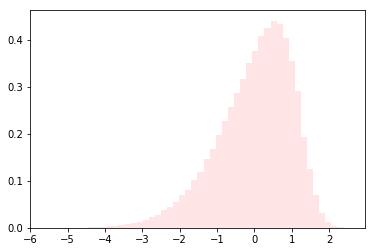

-0.7866071481777321


In [152]:
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
from scipy.stats import skew 

numValues = 100000
maxValue = 100
skewness = -4   #Negative values are left skewed, positive values are right skewed.

random = skewnorm.rvs(a = skewness,loc=maxValue, size=numValues)  #Skewnorm function

random = random - min(random)      #Shift the set so the minimum value is equal to zero.
random = random / max(random)      #Standadize all the vlues between 0 and 1. 
random = random * maxValue         #Multiply the standardized values by the maximum value.
random = (random - np.mean(random))/ np.std(random)


#Plot histogram to check skewness
plt.hist(random,50,density=True, color = 'red', alpha=0.1)
plt.show()
print(skew(random))

-0.0 1.0 -1.6075067169440722


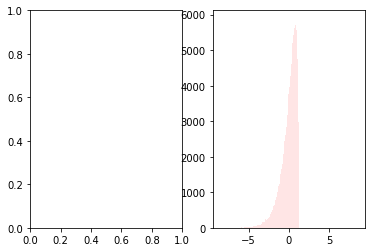

In [284]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2)

alpha = 1.5
loc = 1
beta = 1
data = gamma.rvs(alpha, loc=loc, scale=beta, size=100000) 
m = np.mean(data)
s = np.std(data)
data = (data - m)/s
# zflip = [z[i] for i in range(len(z),-1,-1)]
plt.hist(data,50,density=True, color = 'red', alpha=0.1)
# print(round(np.mean(data)),np.std(data),skew(data))
d2 = [d*-1 for d in data]
# plt.hist(d2,50,density=True, color = 'red', alpha=0.1)
plt.hist(d2,100,color = 'red', alpha=0.1)
m = np.mean(d2)
s = np.std(d2)
sk = np.mean([(d-m)**3/s for d in d2])
print(round(np.mean(d2)),np.std(d2),sk)



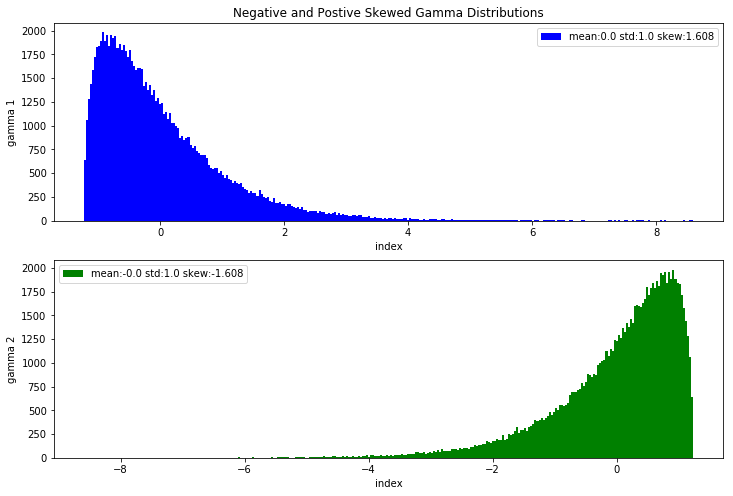

In [293]:

# Now, generate to small plots inside a larger figure, using plt.figure
def multi_subplots(y):
    '''
        y is a 2 dimensional a "matrix-like" np.array, where the dimension 0 is the number of rows,
          and dimension 1 is the number of columns
        For each column, create a subplot.
    '''
    plt.figure(figsize=(12,8))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    # on each iteration of this loop, we create another subplot, BUT NOT ON THE SAME PLO.
    # Previously, we created 2 plots, with different y axis's, on the same plot.
    # Now, we generate 2 plots (subplots).
    for i in range(y.shape[1]):
        plt.subplot(y.shape[1],1,1+i)
        if i<=0:
            plt.title('Negative and Postive Skewed Gamma Distributions')
        dd = y[:, i]
        plt.hist(dd,color=colors[i], bins=300, label=f'mean:{round(np.mean(dd),2)} std:{round(np.std(dd),2)} skew:{round(skew(dd),3)}')
        plt.legend(loc=0)
        plt.axis('tight')
        plt.xlabel('index')
        plt.ylabel(f'gamma {i+1}')
        
gammas = np.array([data,d2]).T
multi_subplots(gammas)

0.0 1.0 -2.0070239466749107


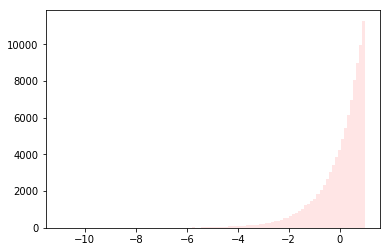

In [228]:
skew(data),skew(d2)

(0.8879187355186087, -0.8879187355186087)

In [307]:
df_pl_symbols1 = pga.get_sql("select distinct symbol from sec_schema.underlying_table where symbol ~* 'pl.*';")


In [313]:
df_pl_symbols2 = df_pl_symbols1.copy()
df_pl_symbols2['yyyy'] = df_pl_symbols2.symbol.str.slice(-2,).astype(int) + 2000
df_pl_symbols2['monthcode'] = df_pl_symbols2.symbol.str.slice(2,3)
df_pl_symbols2 = df_pl_symbols2.sort_values(['yyyy','monthcode'])
df_pl_symbols2.index = list(range(len(df_pl_symbols2)))
df_pl_symbols2 = df_pl_symbols2[df_pl_symbols2.monthcode.isin(['F','J','N','V'])]
pl_symbols = df_pl_symbols2.symbol.values
pl_symbols

array(['PLV10', 'PLF11', 'PLJ11', 'PLN11', 'PLV11', 'PLF12', 'PLJ12',
       'PLN12', 'PLV12', 'PLF13', 'PLJ13', 'PLN13', 'PLV13', 'PLF14',
       'PLJ14', 'PLN14', 'PLV14', 'PLF15', 'PLJ15', 'PLN15', 'PLV15',
       'PLF16', 'PLJ16', 'PLN16', 'PLV16', 'PLF17', 'PLJ17', 'PLN17',
       'PLV17', 'PLF18', 'PLJ18', 'PLN18', 'PLV18', 'PLF19', 'PLJ19',
       'PLN19', 'PLV19', 'PLF20', 'PLJ20', 'PLN20', 'PLV20'], dtype=object)

## End